# Demo: Kubernetes default scheduler

## Discover capabilities of k8s default scheduler for deploying workflows

### 1. Capabilities of k8s default scheduler for deploying workflows

 1. Define different resources for different steps of the workflow.


 2. Define affinity rules for some steps of the workflow.
 
 
 3. Scale some steps of the workflow. (future work)
    


### A Sample workflow 

gathering -> preprocessing -> modeling


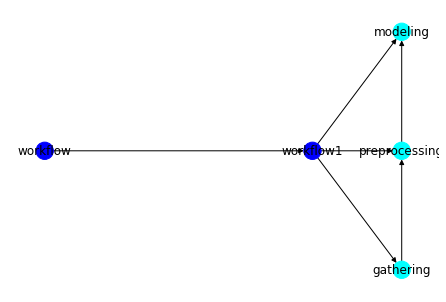

In [51]:
workflower.draw_workflow('workflow')

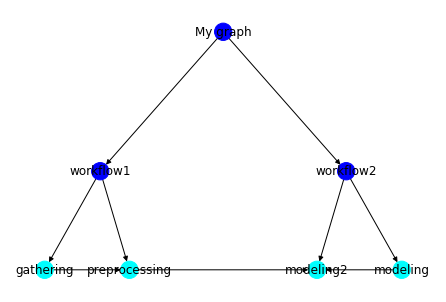

In [62]:
workflower.draw_workflow('My graph')

### 2. Capabilities of k8s default scheduler for deploying workflows

### (1). Define different resources for different steps of the workflow.


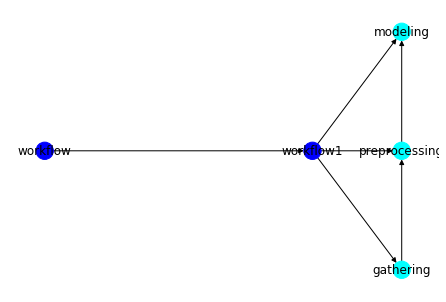

In [51]:
workflower.draw_workflow('workflow')

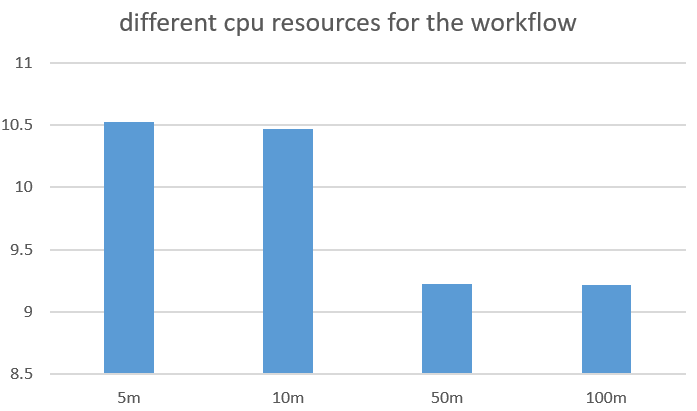

In [59]:
from IPython.display import Image
Image("/gpfs/bsc_home/xpliu/scanflow/kubernetes/picture/results(1).png", width=400, height=400)

In [ ]:
apiVersion: apps/v1
kind: Deployment
metadata:
  labels:
    app: modeling
  name: modeling
spec:
  replicas: 1
  selector:
    matchLabels:
      app: modeling
  strategy:
    type: Recreate
  template:
    metadata:
      labels:
        app: modeling
    spec:
      volumes:
        - name: pv-workflow
          persistentVolumeClaim:
            claimName: pvc-workflow
        - name: pv-tracker
          persistentVolumeClaim:
            claimName: pvc-tracker
      containers:
      - image: 172.30.0.49:5000/modeling
        imagePullPolicy: IfNotPresent
        command: [ "/bin/bash", "-c", "--" ]
        args: [ "while true; do sleep 30; done;" ]
        name: modeling
        resources:
           requests:
             memory: "128Mi"
             cpu: "5m"
           limits:
             memory: "128Mi"
             cpu: "5m"
        volumeMounts:
        - mountPath: /app
          name: pv-workflow
        - mountPath: /mlflow
          name: pv-tracker
      restartPolicy: Always

In [20]:
#dynamic changing the cpu requests and limits

from kubernetes import client, config
import yaml
config.load_kube_config()
apps_api = client.AppsV1Api()

In [53]:
with open("/gpfs/bsc_home/xpliu/scanflow/kubernetes/configs-defaultshceduler/resource/modeling-deployment.yaml") as f:
    dep = yaml.safe_load(f)  
    dep['spec']['template']['spec']['containers'][0]['resources']['requests']['cpu'] = "100m"
    dep['spec']['template']['spec']['containers'][0]['resources']['limits']['cpu'] = "100m"
    resp = k8s_apps_v1.replace_namespaced_deployment(name="modeling", body=dep, namespace="default")

### (2). Scale some steps of the workflow.

In [ ]:
apiVersion: apps/v1
kind: Deployment
metadata:
  labels:
    app: modeling
  name: modeling
spec:
  replicas: 2
  selector:
    matchLabels:
      app: modeling
  strategy:
    type: Recreate
  template:
    metadata:
      labels:
        app: modeling
    spec:
      volumes:
        - name: pv-workflow
          persistentVolumeClaim:
            claimName: pvc-workflow
        - name: pv-tracker
          persistentVolumeClaim:
            claimName: pvc-tracker
      containers:
      - image: 172.30.0.49:5000/modeling
        imagePullPolicy: IfNotPresent
        command: [ "/bin/bash", "-c", "--" ]
        args: [ "while true; do sleep 30; done;" ]
        name: modeling
        resources: {}
        volumeMounts:
        - mountPath: /app
          name: pv-workflow
        - mountPath: /mlflow
          name: pv-tracker
      restartPolicy: Always

### (3). Define affinity rules for some steps of the workflow.

   **default**  : pod of the workflow can be allocated on any host in the cluster
   
   **Node Affinity**  :  all the pods from the workflow are allocated to the same host
      
   **CPU Affinity**   :  all the pods from the workflow are allocated to the same host, and enable exclusive cpuset of 1 CPU for each pod
       
   **CPUMEM Affinity**  :  Same settings as 'CPU affinity', also enable topology manager as 'best-effort', the TopologyManager will attempt to align pod allocations on NUMA nodes as best it can.
   
 https://kubernetes.io/blog/2020/04/01/kubernetes-1-18-feature-topoloy-manager-beta/
 
   **Anti-Affinity**  :  Same settings as 'CPUMEM affinity', but some steps compete for the resource so that need to be allocated separately.

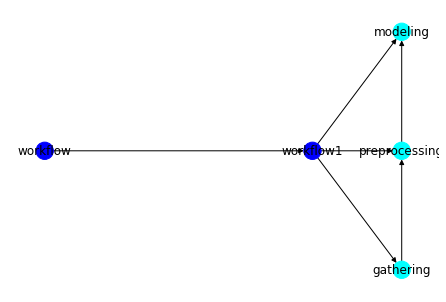

In [51]:
workflower.draw_workflow('workflow')

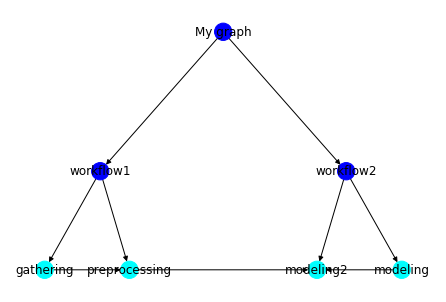

In [62]:
workflower.draw_workflow('My graph')

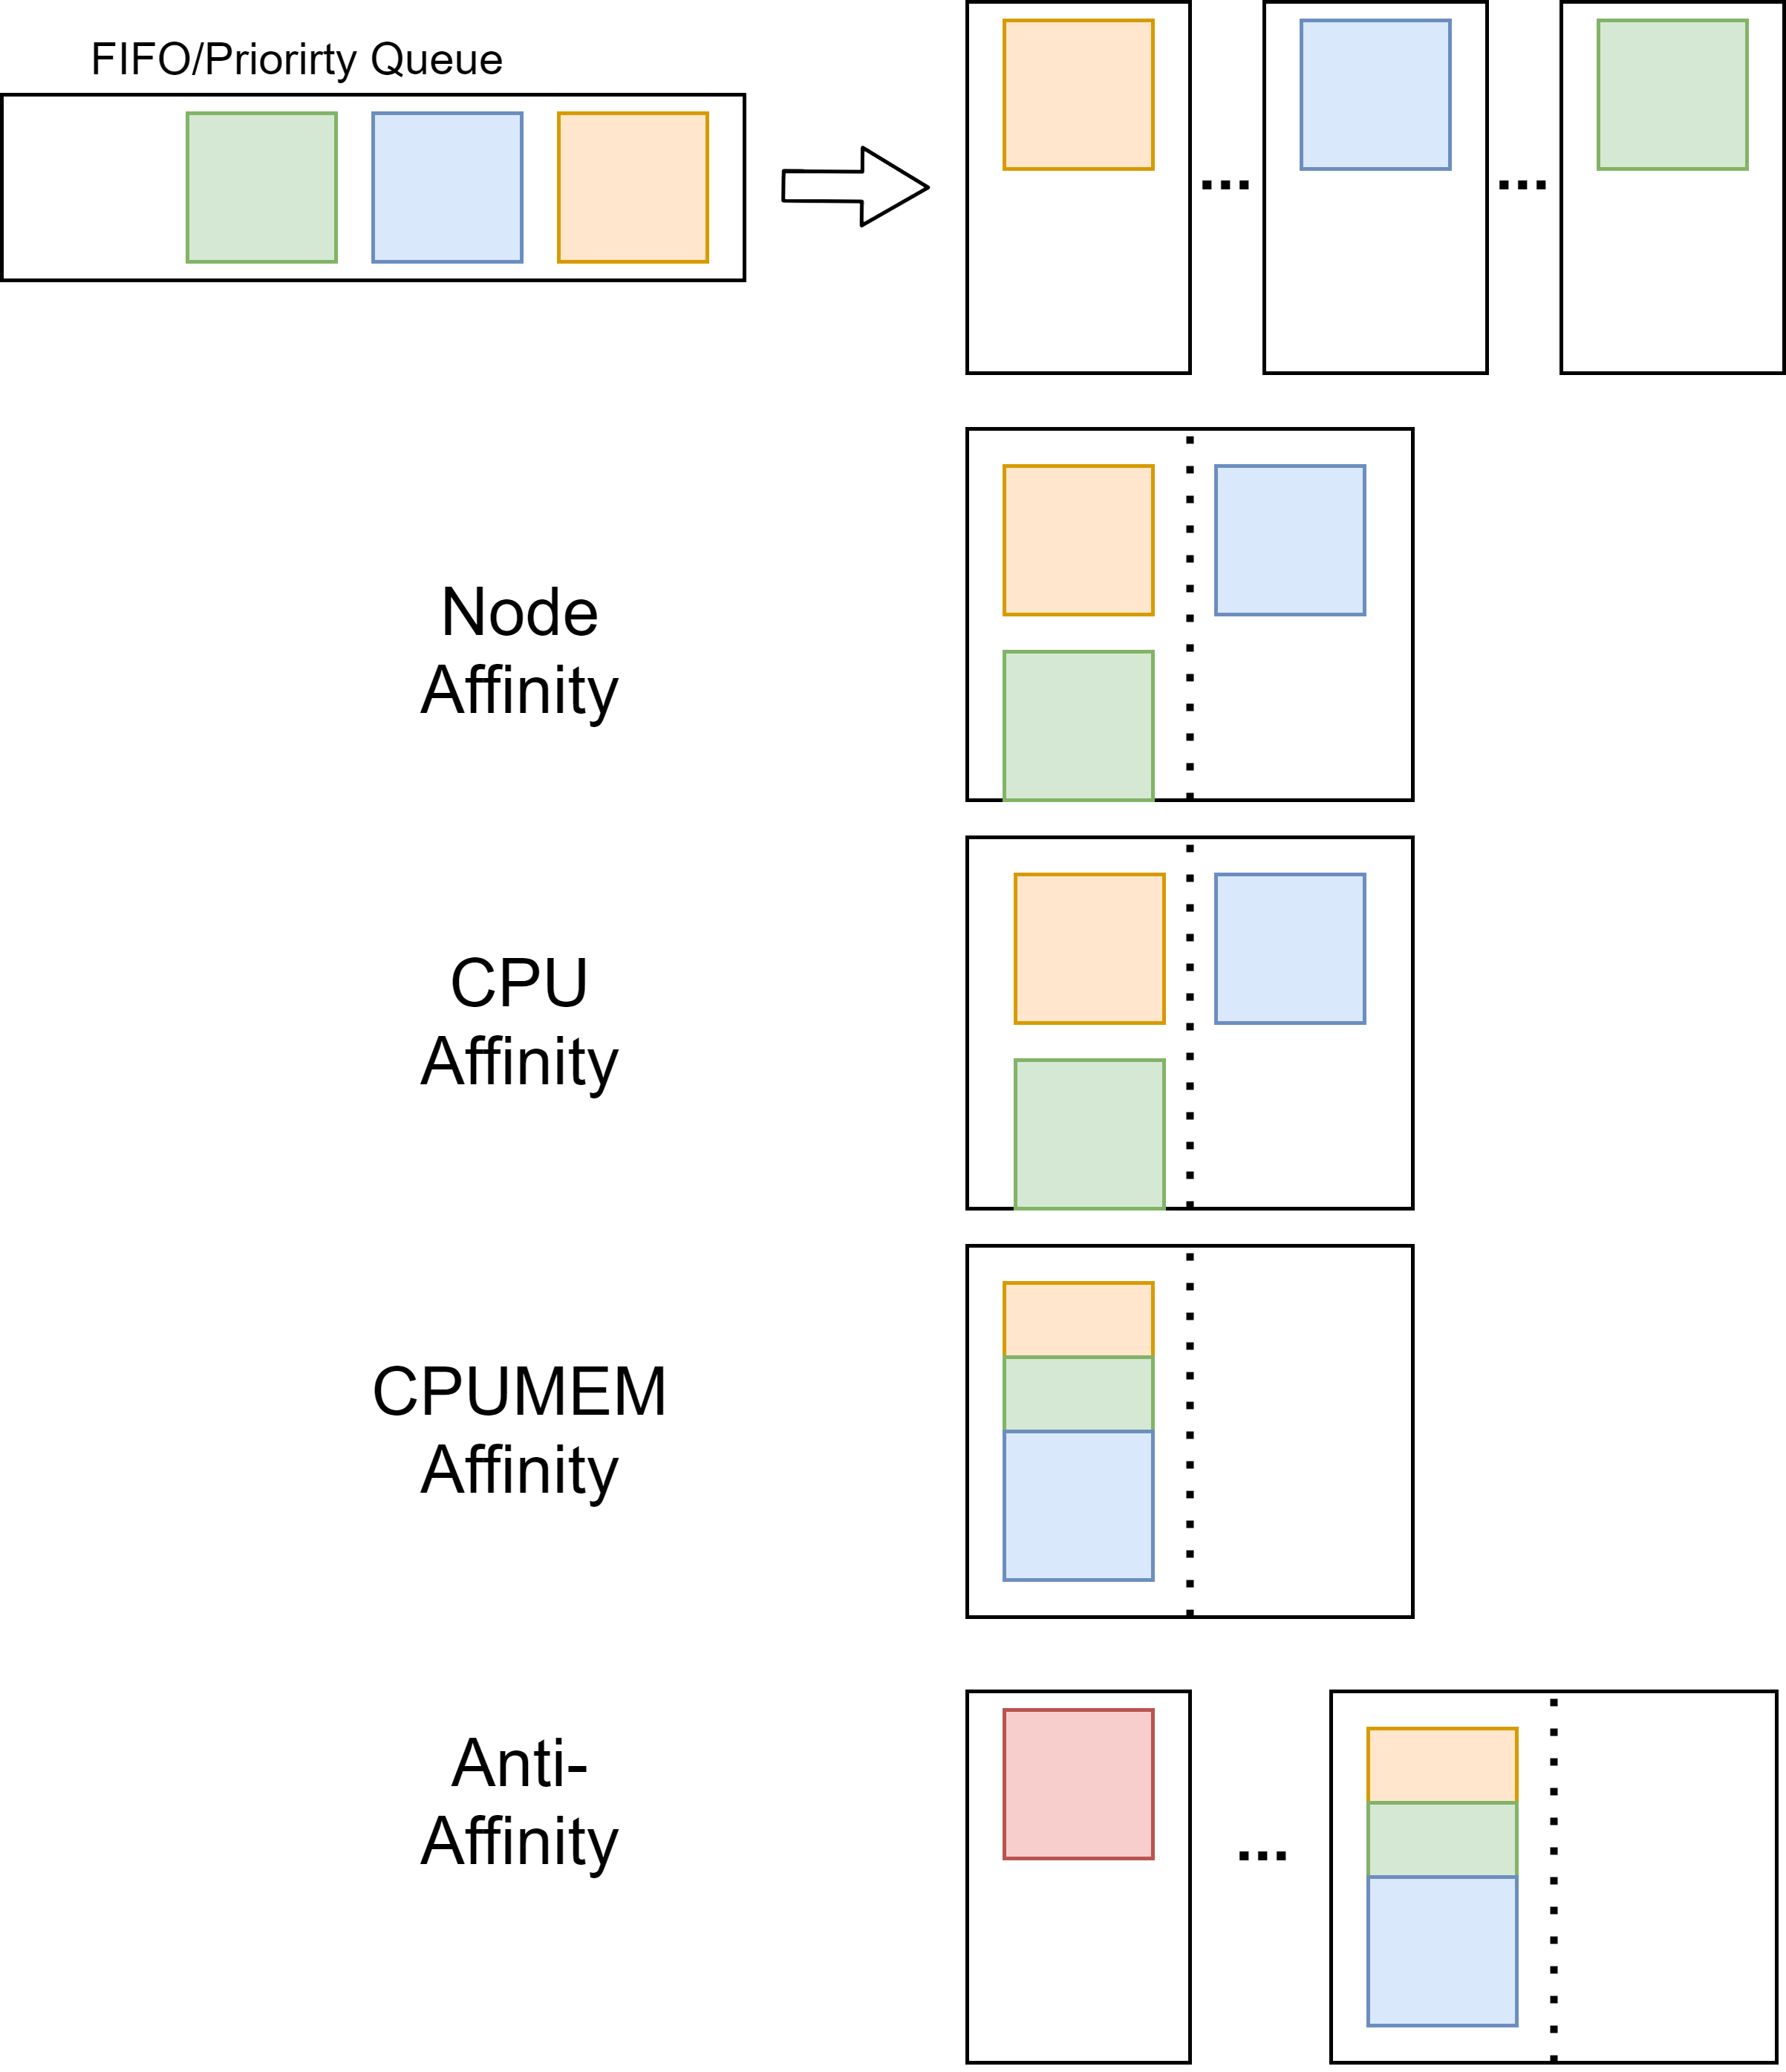

In [60]:
from IPython.display import Image
Image("/gpfs/bsc_home/xpliu/scanflow/kubernetes/picture/scenario.png", width=400, height=400)

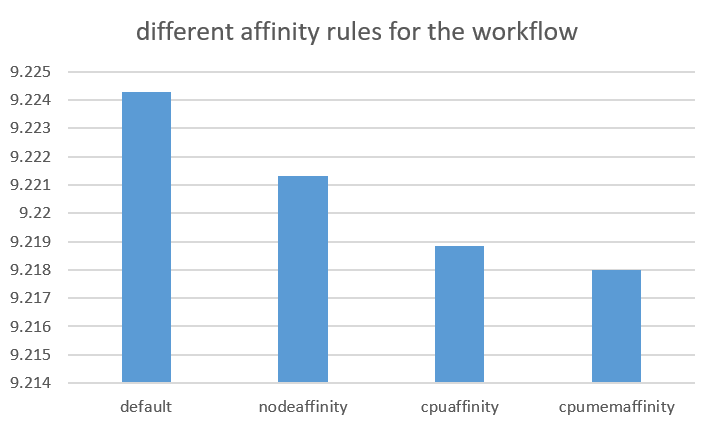

In [58]:
from IPython.display import Image
Image("/gpfs/bsc_home/xpliu/scanflow/kubernetes/picture/results(3).png", width=400, height=400)

In [ ]:
#default

apiVersion: apps/v1
kind: Deployment
metadata:
  labels:
    app: gathering
  name: gathering
spec:
  replicas: 1
  selector:
    matchLabels:
      app: gathering
  template:
    metadata:
      labels:
        app: gathering
    spec:
      volumes:
        - name: pv-workflow
          persistentVolumeClaim:
            claimName: pvc-workflow
        - name: pv-tracker
          persistentVolumeClaim:
            claimName: pvc-tracker
      containers:
      - image: 172.30.0.49:5000/gathering
        imagePullPolicy: IfNotPresent
        command: [ "/bin/bash", "-c", "--" ]
        args: [ "while true; do sleep 30; done;" ]
        name: gathering
        volumeMounts:
          - mountPath: /app
            name: pv-workflow
          - mountPath: /mlflow
            name: pv-tracker
      restartPolicy: Always


In [ ]:
#nodeaffinity

apiVersion: apps/v1
kind: Deployment
metadata:
  labels:
    app: gathering
  name: gathering
spec:
  replicas: 1
  selector:
    matchLabels:
      app: gathering
  template:
    metadata:
      labels:
        app: gathering
    spec:
      volumes:
        - name: pv-workflow
          persistentVolumeClaim:
            claimName: pvc-workflow
        - name: pv-tracker
          persistentVolumeClaim:
            claimName: pvc-tracker
      affinity:
        nodeAffinity:
          requiredDuringSchedulingIgnoredDuringExecution:
            nodeSelectorTerms:
            - matchExpressions:
              - key: nodename
                operator: In
                values:
                - nxt2030
      containers:
      - image: 172.30.0.49:5000/gathering
        imagePullPolicy: IfNotPresent
        command: [ "/bin/bash", "-c", "--" ]
        args: [ "while true; do sleep 30; done;" ]
        name: gathering
        volumeMounts:
          - mountPath: /app
            name: pv-workflow
          - mountPath: /mlflow
            name: pv-tracker
      restartPolicy: Always


In [ ]:
#cpuaffinity

apiVersion: apps/v1
kind: Deployment
metadata:
  labels:
    app: gathering
  name: gathering
spec:
  replicas: 1
  selector:
    matchLabels:
      app: gathering
  template:
    metadata:
      labels:
        app: gathering
    spec:
      volumes:
        - name: pv-workflow
          persistentVolumeClaim:
            claimName: pvc-workflow
        - name: pv-tracker
          persistentVolumeClaim:
            claimName: pvc-tracker
      affinity:
        nodeAffinity:
          requiredDuringSchedulingIgnoredDuringExecution:
            nodeSelectorTerms:
            - matchExpressions:
              - key: nodename
                operator: In
                values:
                - nxt2030
      containers:
      - image: 172.30.0.49:5000/gathering
        imagePullPolicy: IfNotPresent
        command: [ "/bin/bash", "-c", "--" ]
        args: [ "while true; do sleep 30; done;" ]
        name: gathering
        resources:
           requests:
             memory: "128Mi"
             cpu: "1"
           limits:
             memory: "128Mi"
             cpu: "1"
        volumeMounts:
          - mountPath: /app
            name: pv-workflow
          - mountPath: /mlflow
            name: pv-tracker
      restartPolicy: Always


In [ ]:
#memoryaffinity[kubelet.conf]

KUBELET_OPTS="--logtostderr=false \
--v=2 \
--log-dir=/opt/kubernetes/logs/kubelet \
--hostname-override=nxt2026 \
--kubeconfig=/opt/kubernetes/cfg/kubelet.kubeconfig \
--bootstrap-kubeconfig=/opt/kubernetes/cfg/bootstrap.kubeconfig \
--config=/opt/kubernetes/cfg/kubelet-config.yml \
--cert-dir=/opt/kubernetes/ssl \
--network-plugin=cni \
--cni-conf-dir=/etc/cni/net.d \
--cni-bin-dir=/opt/cni/bin \
--root-dir=/opt/kubelet \
--pod-infra-container-image=gcr.io/google_containers/pause-amd64:3.0 \
--system-reserved=memory=30Mi \
--kube-reserved=memory=40Mi \
--topology-manager-policy=best-effort"


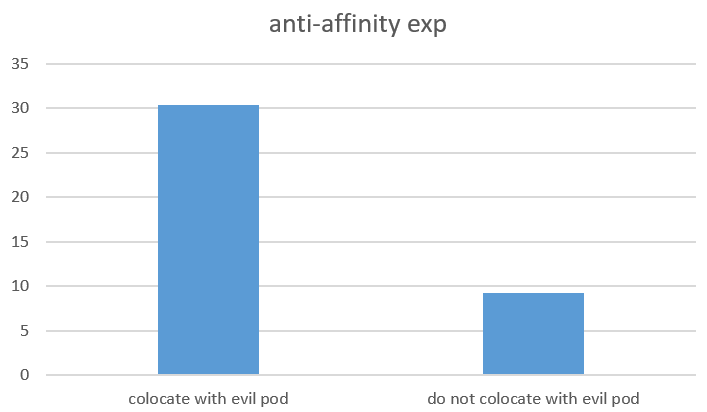

In [66]:
from IPython.display import Image
Image("/gpfs/bsc_home/xpliu/scanflow/kubernetes/picture/results(4).png", width=400, height=400)

In [ ]:
#anti-affinity

apiVersion: apps/v1
kind: Deployment
metadata:
  labels:
    app: modeling2
  name: modeling2
spec:
  replicas: 1
  selector:
    matchLabels:
      app: modeling2
  strategy:
    type: Recreate
  template:
    metadata:
      labels:
        app: modeling2
    spec:
      volumes:
        - name: pv-workflow
          persistentVolumeClaim:
            claimName: pvc-workflow
        - name: pv-tracker
          persistentVolumeClaim:
            claimName: pvc-tracker
      affinity:
        podAntiAffinity:
          requiredDuringSchedulingIgnoredDuringExecution:
          - labelSelector:
              matchExpressions:
              - key: app
                operator: In
                values:
                - modeling
            topologyKey: kubernetes.io/hostname
      containers:
      - image: 172.30.0.49:5000/modeling
        imagePullPolicy: IfNotPresent
        command: [ "/bin/bash", "-c", "--" ]
        args: [ "while true; do sleep 30; done;" ]
        name: modeling
        resources:
           requests:
             memory: "128Mi"
             cpu: "1"
           limits:
             memory: "128Mi"
             cpu: "1"
        volumeMounts:
        - mountPath: /app
          name: pv-workflow
        - mountPath: /mlflow
          name: pv-tracker
      restartPolicy: Always

In [ ]:
#stress pod 
#stress --cpu 35 --io 1 --vm 2 --vm-bytes 128M --timeout 120s

apiVersion: v1
kind: Pod
metadata:
  name: antiaffinity-pod
spec:
  containers:
  - name: antiaffinity-pod
    image: progrium/stress
    command: [ "/bin/bash", "-c", "--" ]
    args: [ "while true; do sleep 30; done;" ]

        
 affinity:
    podAntiAffinity:
      requiredDuringSchedulingIgnoredDuringExecution:
      - labelSelector:
          matchExpressions:
          - key: name
            operator: In
            values:
            - antiaffinity-pod
        topologyKey: kubernetes.io/hostname
